In [1]:
####ACTIVE CELL#### 
#Import
import glob
import timeit
import numpy as np
import cv2 as cv
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import copy
from matplotlib import colors
from math import pi
import os
import re
import sys

#Importing project setup variables
from project_setup import *

#To run project notebooks in subfolders as from root folder
sys.path.append('../../' if SETUP_WORK_LOCAL else '../')

###Import self-written library
import featexlib
from featexlib import Debug as dbug
from featexlib import *

plt.style.use('seaborn-whitegrid')

#for autorealoading the submodules
%load_ext autoreload
%autoreload 2

In [2]:
####ACTIVE CELL#### 
#SHOW PROJECT SETUP
print("########Project setup#############")
print("SETUP_WORK_LOCAL",SETUP_WORK_LOCAL)
print("SETUP_PROJECT_NAME",SETUP_PROJECT_NAME)
print("SETUP_Y_IS_RGB",SETUP_Y_IS_RGB)
print("SETUP_NUM_OF_CLASSES",SETUP_NUM_OF_CLASSES)
print("SETUP_LIST_OF_CLASS_COLORS",SETUP_LIST_OF_CLASS_COLORS)
print("SETUP_LIST_OF_CLASS_INDEXES",SETUP_LIST_OF_CLASS_INDEXES)
print("SETUP_CV_READ_MODE",SETUP_CV_READ_MODE)
print("SETUP_BASE_DIR",SETUP_BASE_DIR)

########Project setup#############
SETUP_WORK_LOCAL True
SETUP_PROJECT_NAME scrapid
SETUP_Y_IS_RGB True
SETUP_NUM_OF_CLASSES 11
SETUP_LIST_OF_CLASS_COLORS [0, 64, 32896, 8388608, 32768, 192, 8388736, 4194448, 20624, 52443, 10911041]
SETUP_LIST_OF_CLASS_INDEXES [0, 64, 32896, 8388608, 32768, 192, 8388736, 4194448, 20624, 52443, 10911041]
SETUP_CV_READ_MODE 1
SETUP_BASE_DIR ../../data/scrapid/


In [3]:
###ACTIVE CELL###
###Get names of checked images from folder, will use them as filter
filtered_list_input = Image_generator.get_file_names_in_folder(files_dir = SETUP_BASE_DIR +"images/1_channel/checkedannotations")
print('Found file names:', len(filtered_list_input))

Found file names: 273


In [14]:
###ACTIVE CELL###
###Generate and save dataset
if not SETUP_Y_IS_RGB:
    read_dir_x = SETUP_BASE_DIR +"images/1_channel/images_protocols_matched"
    read_dir_y = SETUP_BASE_DIR +"images/1_channel/masks"
    file_filter_regex = r'/([^/]+)\.png'
    filtered_list = filtered_list_input 
else:
    read_dir_x = SETUP_BASE_DIR + "images/3_channels/JPEGImages"
    read_dir_y = SETUP_BASE_DIR + "images/3_channels/SegmentationClassPNG"
    file_filter_regex = r'/([^/]+)\.jpg'
    filtered_list = None 
    
save_dir = SETUP_BASE_DIR + "data_training/"
save_dir = SETUP_BASE_DIR + "data_preprocess/" #dataset for scaler
save_name = 'scrapid_11c_256x256'
num_pics_in_file = None #1440

##Image preprocessing pipeline. Resizing and splitting images only. Augentation and one-hot encoding will be done in training task.
image_generator = Image_generator(
    Image_generator.Pipeline_x_y_images(
        common_layers = [
            #Image_generator.Mod_linear_transf(l=0.2, r=0.0, t = 0.2, b = 0.0, rand = False, target="all"),
            #Image_generator.Mod_add_padding(pl=2, pr=2, pt=2, pb=2, target="all"),
            #Image_generator.Mod_crop(t=0, l=0, h=500, w=500, target="all"),
            #Image_generator.Mod_reshape(shape=(...,None),target="y"),
            Image_generator.Mod_resize(size=(768,256), target="x"),
            ###interpolation cv.INTER_NEAREST is required!!!!!
            Image_generator.Mod_resize(size=(768,256), target="y", interpolation = cv.INTER_NEAREST),
            Image_generator.Mod_split(size=(256,256), target="all"),
            #Image_generator.Mod_duplicate(num=3)
        ],
        special_layers = [
                [
                    ###These steps are performed in training task
                    #Image_generator.Mod_shift(sh_h=100, sh_v=100, rand = True, interpolation_saved = cv.INTER_NEAREST, borderValue=0, borderValue_saved=0),
                    #Image_generator.Mod_rotate(angle=180, rand = True, interpolation_saved = cv.INTER_NEAREST, borderValue=0, borderValue_saved=0),
                    #Image_generator.Mod_one_hot( list_of_codes, rgb_mode = sp_y_is_rgb, target="y")
                ]
        ]
    )
)
    

####Dataset generator function####
def generate_and_save_datasets(read_dir_x = read_dir_x,
                               read_dir_y = read_dir_y,
                               file_filter_regex = file_filter_regex,
                               save_dir = save_dir,
                               save_name = save_name,
                               filtered_list = filtered_list,
                               num_pics_in_file = num_pics_in_file,
                               size=(3557,1071)
                               ):

    filtered_list = Image_generator.get_file_names_in_folder(files_dir=read_dir_x,file_filter_regex = file_filter_regex) if filtered_list is None else filtered_list
    bunch_size = len(filtered_list) if num_pics_in_file is None else num_pics_in_file  
    num_bunches =  len(filtered_list)//bunch_size if len(filtered_list)%bunch_size ==0 else len(filtered_list)//bunch_size + 1
    print('Will be generated %s files'%num_bunches)
    for i in range(num_bunches):
        bunch_list = filtered_list[bunch_size*i:bunch_size*(i+1)]
        if any(bunch_list):
            
            ###Reading files  
            images_x, images_y_raw = Image_generator.load_from_folders_xy(
                save_dir_x = read_dir_x,
                save_dir_y = read_dir_y,
                name_list = bunch_list,
                size=size,
                file_filter_regex = file_filter_regex,
                cv_read_mode = SETUP_CV_READ_MODE,
                recursive = True,
                interp_y = cv.INTER_NEAREST
            )

            #Generate images. Run twice while need to export images_y_raw color images. TODO: optimisation
            x_result, y_result = image_generator(images_x, images_y_raw)
            
            #images_y_raw_rgb = Image_generator.one_hot_to_rgb(y_result,list_of_codes_colors)
            
            #Saving debug images
            #dbug.show_images_list(np.concatenate([x_result,images_y_raw_rgb.astype('uint8')], axis=1), col_number = 2, save_name='export') 
            
            #Saving dump
            file_name="%s_%s_%s"%(save_name,len(x_result),(i+1))
            Image_generator.save_data(x_result, y_result, save_dir = save_dir, name=file_name)
            #Image_generator.save_data(x_result, y_result, images_y_raw_rgb, save_dir = save_dir, name=file_name)
            
            print('%s images saved in file %s'%(len(x_result),save_dir+file_name))
            
generate_and_save_datasets()

Will be generated 1 files
Totally 10 x images found from name list
Valid amount of pairs 10 
30 images saved in file ../../data/scrapid/data_preprocess/scrapid_11c_256x256_30_1


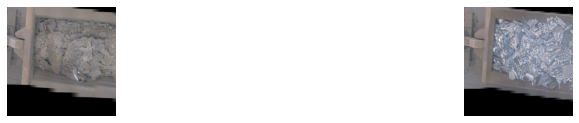

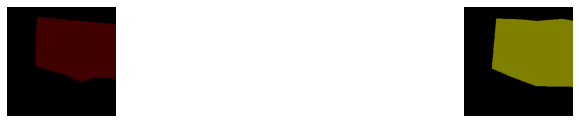

In [5]:
####DEBUG CELL####
####TEST CELL#####
x_load, y_load  = Image_generator.load_data(save_dir = save_dir, name="scrapid_11c_256x256_30_1")

dbug.show_images_list(x_load[:2], col_number = 2)
dbug.show_images_list(y_load[:2], col_number = 2)

Totally 273 x images found from name list
Valid amount of pairs 273 
Num classes 11
Shape (273, 1071, 3557)
Unique classes: [ 0  2  3  4  5  6  8  9 10]


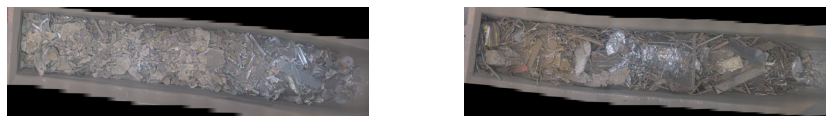

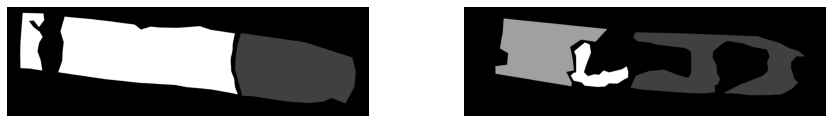

In [9]:
###DEBUG CELL###
###FROM ONE CHANNEL Y
###Prepare X dataset, reading from directory

images_x, images_y_raw = Image_generator.load_from_folders_xy(
    save_dir_x = SETUP_BASE_DIR + "images/1_channel/images_protocols_matched",
    save_dir_y = SETUP_BASE_DIR + "images/1_channel/masks",
    name_list = filtered_list_input,
    size=(3557,1071),
    file_filter_regex = r'/([^/]+)\.png',
    cv_read_mode = SETUP_CV_READ_MODE,
    recursive = True,
    interp_y = cv.INTER_NEAREST
)

dbug.show_images_list(images_x[:2], col_number = 2)
dbug.show_images_list(images_y_raw[:2], col_number = 2)
print('Num classes', images_y_raw.max()+1)
print('Shape',images_y_raw.shape)
print('Unique classes:', np.unique(images_y_raw))

Totally 10 x images found
Valid amount of pairs 10 
Shape (10, 1071, 3557, 3)


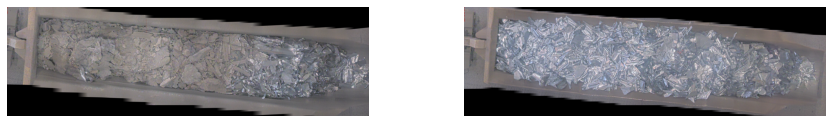

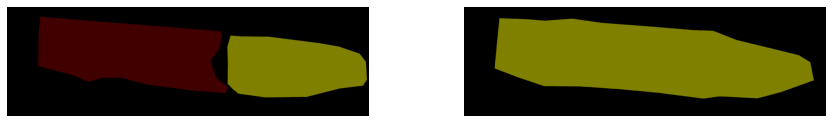

In [5]:
###DEBUG CELL###
###FROM RGM CHANNEL Y
###Prepare X dataset, reading from directory

images_x, images_y_raw = Image_generator.load_from_folders_xy(
    save_dir_x = SETUP_BASE_DIR + "images/3_channels/JPEGImages",
    save_dir_y = SETUP_BASE_DIR + "images/3_channels/SegmentationClassPNG",
    size=(3557,1071),
    file_filter_regex = r'/([^/]+)\.jpg',
    cv_read_mode = SETUP_CV_READ_MODE,
    recursive = False,
    interp_y = cv.INTER_NEAREST
)

dbug.show_images_list(images_x[:2], col_number = 2)
dbug.show_images_list(images_y_raw[:2], col_number = 2)
print('Shape',images_y_raw.shape)

RGB decimal code is 64


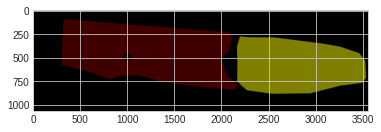

In [6]:
###DEBUG CELL###
###Find new color codes
circle_color = (250, 70, 70) #Set rgb color for point
arr_num = 0 ###Put coords here
coords = (1000,500) ###Put pic number
######################################

if not SETUP_Y_IS_RGB:
    circle_color = 0

#Help function to get decimal code of color
def rgb_to_dec(inp):
    return inp[0]*65536+inp[1]*256+inp[2]

#Select an image
pic = np.array(images_y_raw[arr_num])
pic_c = cv.circle(pic, coords, 30, 0, 20)
dbug.show_image(pic_c)

if SETUP_Y_IS_RGB: 
    print('RGB decimal code is', rgb_to_dec(pic[tuple(reversed(coords))]))
else:
    print('Decimal code is', pic[tuple(reversed(coords))])

In [7]:
###DEBUG CELL###
##Reduce dataset
images_x, images_y_raw = images_x[0:10,...], images_y_raw[0:10,...] 

x.shape = (30, 256, 256, 3) , y.shape = (30, 256, 256, 11)


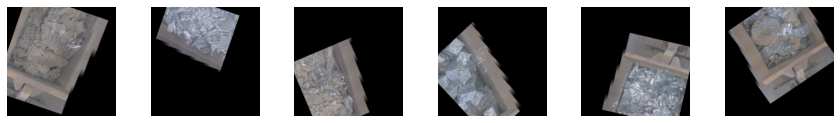

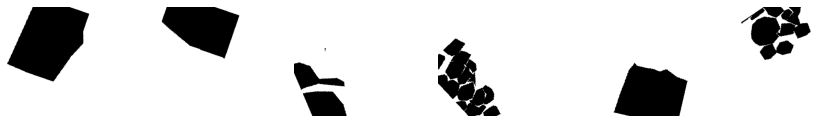

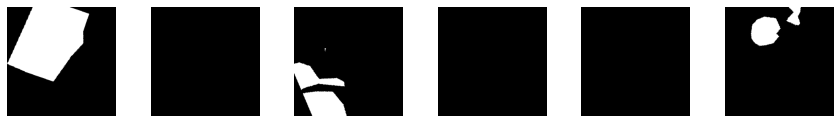

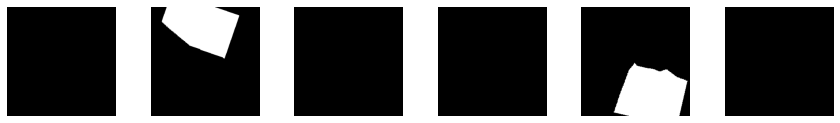

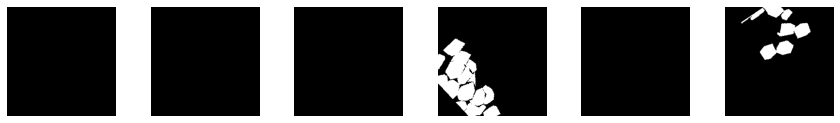

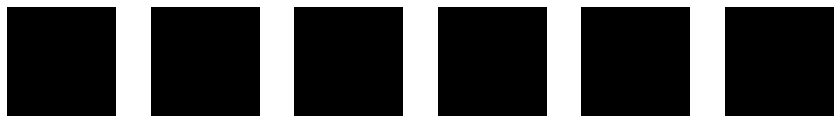

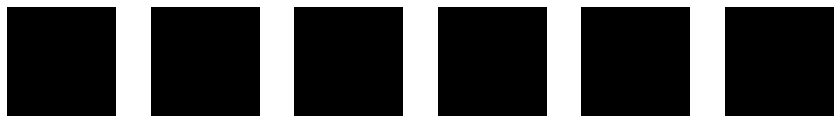

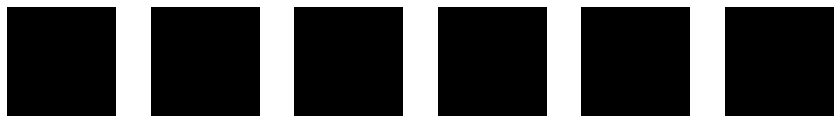

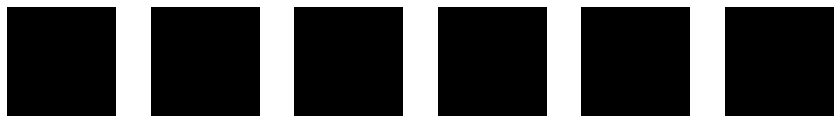

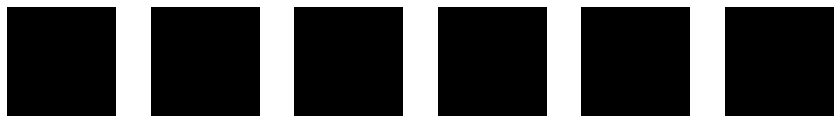

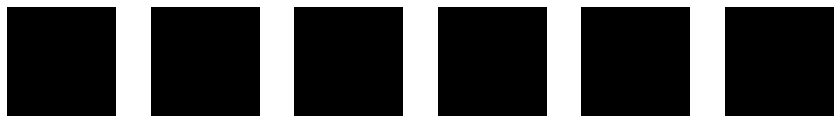

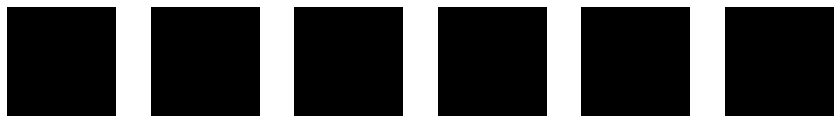

In [8]:
###DEBUG CELL###
#Configure image generation pipeline, based on Image_generator class
bill_img_gen = Image_generator(
    Image_generator.Pipeline_x_y_images(
        common_layers = [
            #Image_generator.Mod_linear_transf(l=0.2, r=0.0, t = 0.2, b = 0.0, rand = False, target="all"),
            #Image_generator.Mod_add_padding(pl=2, pr=2, pt=2, pb=2, target="all"),
            #Image_generator.Mod_crop(t=0, l=0, h=500, w=500, target="all"),
            #Image_generator.Mod_reshape(shape=(...,None),target="y"),
            Image_generator.Mod_resize(size=(768,256), target="x"),
            Image_generator.Mod_resize(size=(768,256), target="y", interpolation = cv.INTER_NEAREST),
            Image_generator.Mod_split(size=(256,256), target="all"),
            #Image_generator.Mod_duplicate(num=3)
            
            ###interpolation cv.INTER_NEAREST is required!!!!!
        ],
        special_layers = [
                [
                    Image_generator.Mod_shift(sh_h=100, sh_v=100, rand = True, interpolation_saved = cv.INTER_NEAREST, borderValue=0, borderValue_saved=0),
                    Image_generator.Mod_rotate(angle=180, rand = True, interpolation_saved = cv.INTER_NEAREST, borderValue=0, borderValue_saved=0),
                    Image_generator.Mod_one_hot( SETUP_LIST_OF_CLASS_INDEXES, rgb_mode = SETUP_Y_IS_RGB, target="y")
                ]
        ]
    )
)

#Generate images. Run twice while need to export images_y_raw color images. TODO: optimisation
x_result, y_result = bill_img_gen(images_x, images_y_raw)

#Show some result images
print('x.shape =',x_result.shape,',', 'y.shape =',y_result.shape)

#Show some result
dbug.show_images_list(x_result[0:6,...], col_number = 6) 
for c in range(SETUP_NUM_OF_CLASSES):
    dbug.show_images_list(y_result[0:6,...,c], col_number = 6) 

In [9]:
###DEBUG CELL###
###NOT USED###

#Make 1-hot coded y-multiarray from multiclass picture
def get_classes_from_multiclass(inp_y, rgb = True):
    print(inp_y.shape)
    y_colors = np.array([])
    if rgb:
        y_colors = (inp_y[:,:,:,0]*65536+inp_y[:,:,:,1]*256+inp_y[:,:,:,2])[...,None] 
    else:
        y_colors = inp_y
    out = []
    for c in list_of_codes:
        out.append((y_colors==c).astype(int)) 
    return np.concatenate(out, axis=3)

#y_result = get_classes_from_multiclass(images_y_raw_proc, rgb=sp_y_is_rgb)

#Show some result
#for c in range(len(list_of_codes)):
#    dbug.show_images_list(y_result[0:6,...,c], col_number = 6) 
    
#print('y shape',y_result.shape)


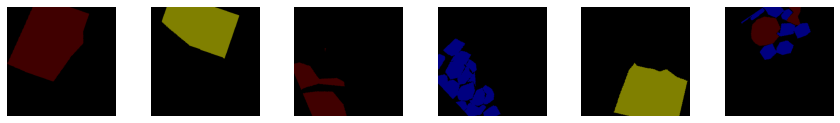

In [10]:
###DEBUG CELL###
###Making RBG y pics from one channel data
images_y_raw_rgb = Image_generator.one_hot_to_rgb(y_result,SETUP_LIST_OF_CLASS_COLORS)
dbug.show_images_list(images_y_raw_rgb[:6,...], col_number = 6) 

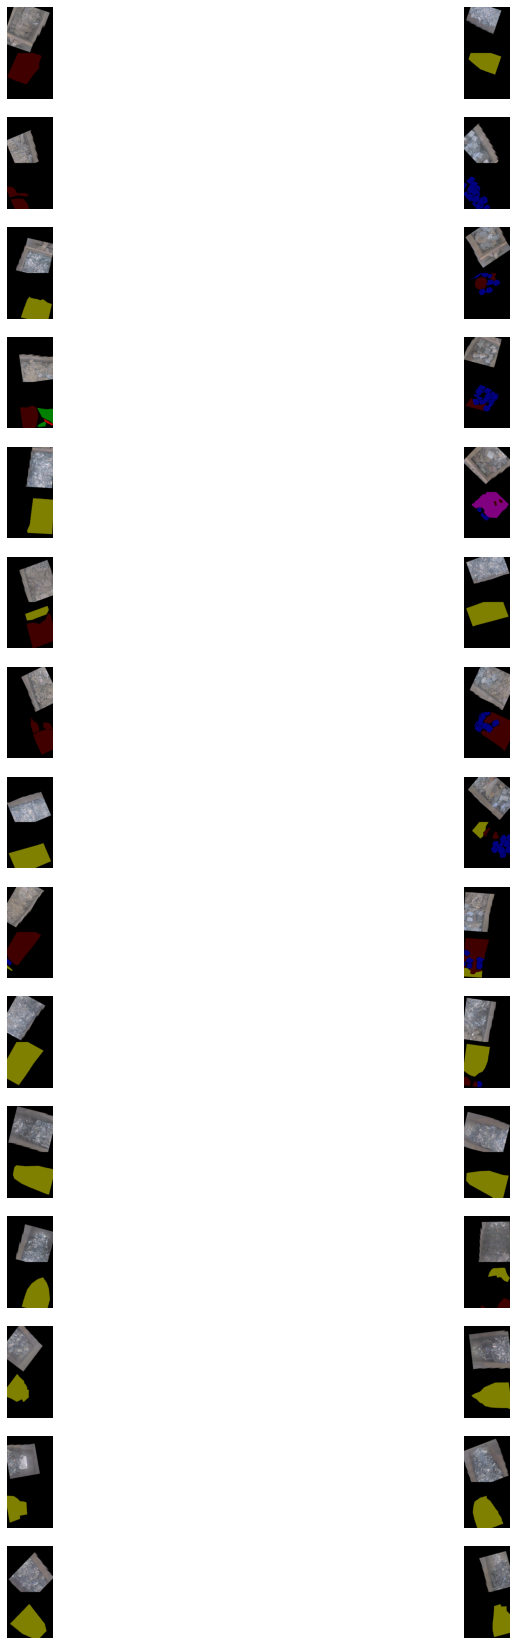

In [11]:
###DEBUG CELL###
###Making export image for check
###Combine together original photo and rgb class mapping and save to the folder as bunch of files.
###Exporting images
dbug.show_images_list(np.concatenate([x_result,images_y_raw_rgb.astype('uint8')], axis=1), col_number = 2, save_dir= SETUP_BASE_DIR + "debug_images", save_name='export') 

In [12]:
###DEBUG CELL###
###Save data to file
Image_generator.save_data(x_result, y_result, images_y_raw_rgb, save_dir = SETUP_BASE_DIR + "data_debug/", name="scrapid_11c_256x256_30_1")

x_load.shape = (30, 256, 256, 3) , y_load.shape = (30, 256, 256, 11)


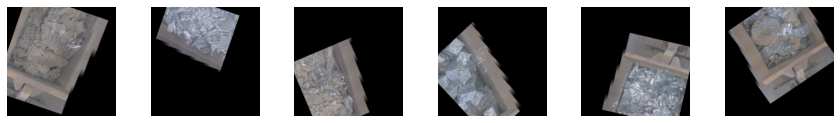

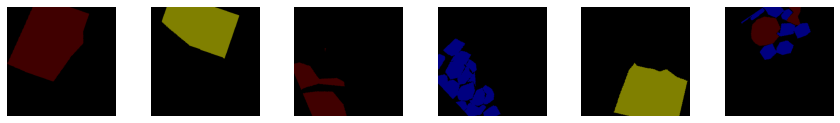

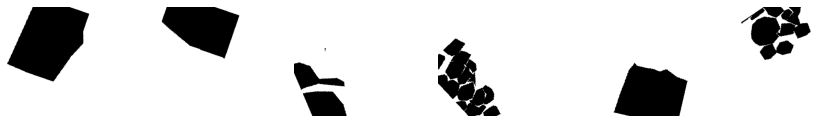

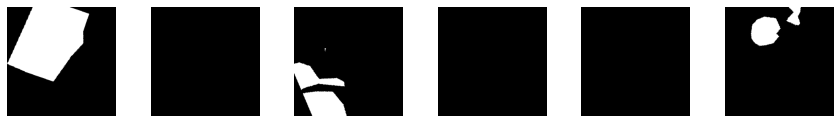

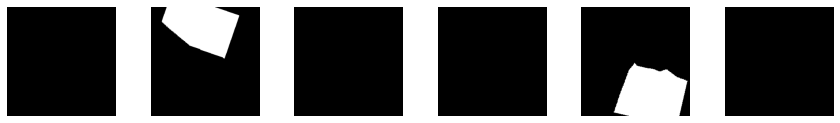

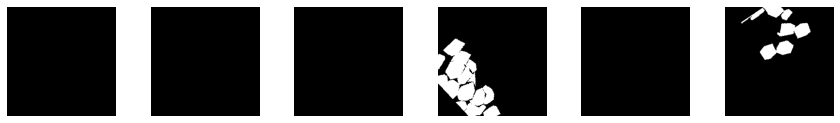

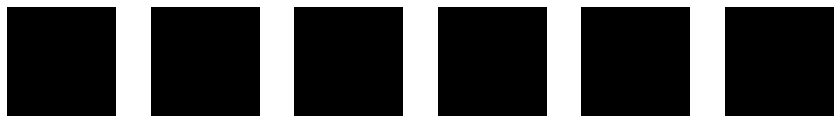

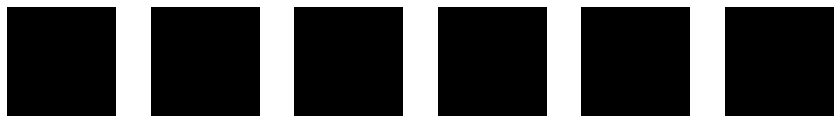

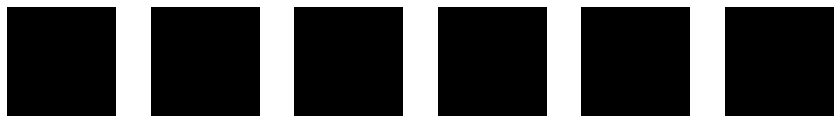

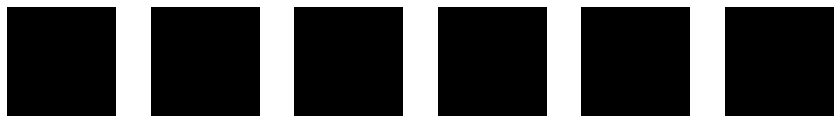

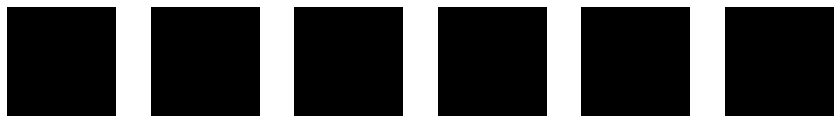

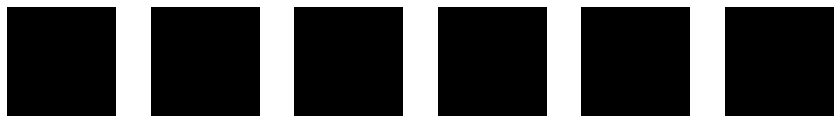

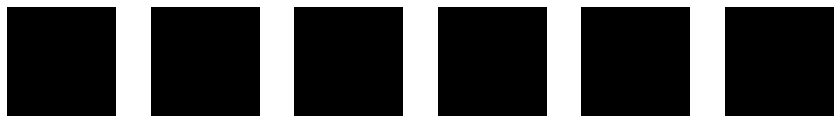

In [13]:
###DEBUG CELL###
###Load data
###Testing that data has been saved and can be loaded

x_load, y_load , y_load_raw  = Image_generator.load_data(SETUP_BASE_DIR + "data_debug/", name="scrapid_11c_256x256_30_1")

#Show some result images
print('x_load.shape =',x_load.shape,',', 'y_load.shape =',y_load.shape)
dbug.show_images_list(x_load[:6], col_number = 6)
dbug.show_images_list(y_load_raw[:6], col_number = 6)
for c in range(y_load.shape[-1]):
    dbug.show_images_list(y_load[:6,...,c], col_number = 6) 